**

In [30]:
#importing required packages 
!pip install regex
!pip install statsmodels
!pip install imblearn
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import sklearn
from sklearn import preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
df = pd.read_csv('Project2_Data.csv')
labels = pd.read_csv('Project2_Data_Labels.csv')
df = pd.concat([df, labels], axis = 1)
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0.0,May,1,1,1,2,New_Visitor,True,True
1,0,0.0,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0.0,Mar,2,2,4,2,Returning_Visitor,False,False
2,4,37.5,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0.0,Nov,2,2,9,2,New_Visitor,False,False
3,4,115.7,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0.0,Nov,1,1,2,3,Returning_Visitor,False,False
4,1,60.0,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0.0,May,2,2,3,4,Returning_Visitor,False,False


Exploratory Data Analysis


Reviewing size of dataset, along with null counts, and data types

Next the 17 variables in the dataset will be explored in an efficient manner.

The approach of this EDA:

-Checking data quality

-Explore variables
        
        -group variables based on their informational content

-Search for strong correlations between independent variables 

-Checking for outliers

-Apply feature engineering methods and how they change the distribution of values

-Fit data to kmeans and hierarchial clustering models

-Observe and interpret results

-Highlight generalizations





**Data Quality**

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [32]:
#check for duplicates
df.duplicated().sum()

125

Some categorical variables may have to be converted to objects and booleans for the model to properly intepret each variable's true nature. For example, SpecialDay has values of 1.0 and 0.0 and can therefore me considered a boolean. Addditionally, there are categorical variables with discrete numerical variables that are being interpreted as integers. There are 125 duplicate records that need to be dropped. All of these changes will take place in a preprocessing function that will prepare the data for modeling. 


In [33]:
df['Revenue'].value_counts()

Revenue
False    10422
True      1908
Name: count, dtype: int64

In [34]:

#use preprocessing function to clean data

def dapp(dataframe):
        """ 
    Data Analytics PreProcessor function performs basic data preprocesing to the dataset. It removes duplucates, converts discrete numerical class labels to objects.

        Args:
            dataframe : dataframe to be preprocessed.
        
        Returns: dataframe with no duplicate records, and converted class labels to objects.


        """
        #gather duplicate records 
        duplicates = dataframe.duplicated()
        #gather boolean class labels that are int or float
        bools = ['SpecialDay']
        categorical = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']

        #convert discrete numerical class labels to objecs, and floats and integers to booleans
        dataframe[categorical] = dataframe[categorical].astype(object)
        dataframe[bools] = dataframe[bools].astype(bool)

        #remove duplicates
        dataframe = dataframe.drop_duplicates()
        

        return dataframe

df = dapp(df)

#check to see if function runs successfully 
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 12200 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12200 non-null  int64  
 1   Administrative_Duration  12200 non-null  float64
 2   Informational            12200 non-null  int64  
 3   Informational_Duration   12200 non-null  float64
 4   ProductRelated           12200 non-null  int64  
 5   ProductRelated_Duration  12200 non-null  float64
 6   BounceRates              12200 non-null  float64
 7   ExitRates                12200 non-null  float64
 8   PageValues               12200 non-null  float64
 9   SpecialDay               12200 non-null  bool   
 10  Month                    12200 non-null  object 
 11  OperatingSystems         12200 non-null  object 
 12  Browser                  12200 non-null  object 
 13  Region                   12200 non-null  object 
 14  TrafficType              12

**Grouping Variables**

The first group of variables are related to the number of pages and time spent on each page.
There are 3 types of pages being observed:

-Administrative

-Informational

-Product Related

Each page type has a pair of variables associated with it, for example:

product_related : the number of product related pages visited by a customer

product_related_duration : the time spent by the customer on each product related page

Factors recording date will alsobe included for the analysis because it may reveal additional insight.

<Axes: >

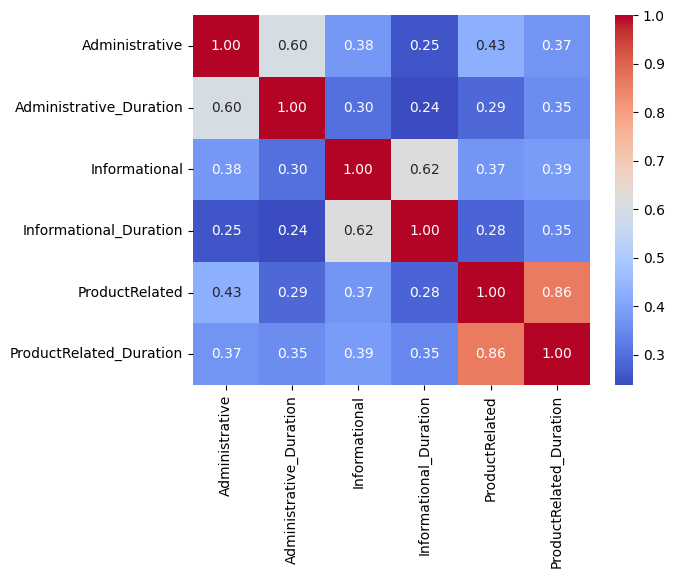

In [35]:
pagetypes = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration' ]
correlations = df[pagetypes].corr()
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt = '.2f')

There should be high correlations between the time spent on the website and the number of pages the customer clicks through. However this assumption is apparent only in the product related pages. This requires further investigation, which can be initiated by looking at total number of pages clicked through for each page category. 



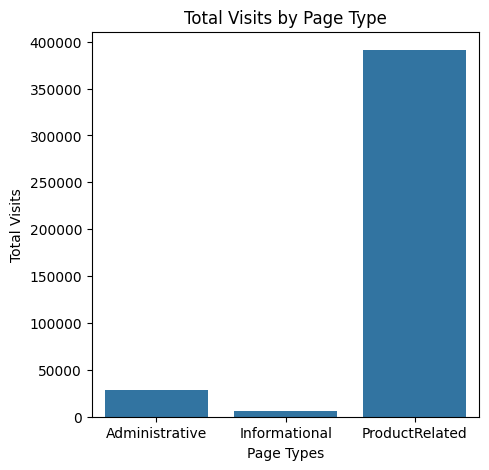

,Page Type,Pages Visited
0,Administrative,28546
1,Informational,6209
2,ProductRelated,391111


In [36]:
#create a dictionary to extract values from into dataframe there will be a key for each page type and its value pair will be the sum of the pages visited.

sums_table = {}
for i in pagetypes:
    if 'Duration' not in i:
        sums_table[i] = df[i].sum()

#extract key value pairs from the dictionary into dataframe and name columns 
df_sums = pd.DataFrame(list(sums_table.items()), columns = ['Page Type', 'Pages Visited'])



plt.figure(figsize=(5,5))
sns.barplot(data = df_sums, x = 'Page Type', y = 'Pages Visited')
plt.xlabel('Page Types')
plt.ylabel('Total Visits')
plt.title('Total Visits by Page Type')
plt.show()

#show table of pagetypes and total visits
df_sums

Product related pages are the more visited than the rest of the page categories combined. This can exolain why the expectation of high correlation is only apparent in product related pages. **Feature selection can be reduced by excluding informational and administrative page types since the objective of this project is to identify sessions in which a customer buys a product**. In other words, the objective of the project is to classify whether or not a customer visiting a product specific page will buy a product. **Models will be built for both duration and visits** because both features measure how long a customer is on the website for in different ways. Duration can indicate how long a customer spends viewing products while visits can exhibit how many products a visitor is viewing. 

The second set of features measure the customer's tendencies, or behavior , on the website. Customer tendencies such as total visits a customer makes before purchasing a product. This group of features contain percentage data like the first group of variables and will be observed alongside the date variables. The following values are recorded by Google Analytics:


bounce rate : percentage of customers that arrive at the site and exit without engaging or clicking on any of the contents. 

exit rate : the ratio of customers leaving from a specific webpage (without buying anything) to the total number of visitors that webpage gets.

page values : average amount of visits to a page before a customer completes a purchase.

Product related variable will be included to enhance the feature selection process because comparing the visits of product related pages to bounce rate and exit rate will show how attrictve product pages are. 

<Axes: >

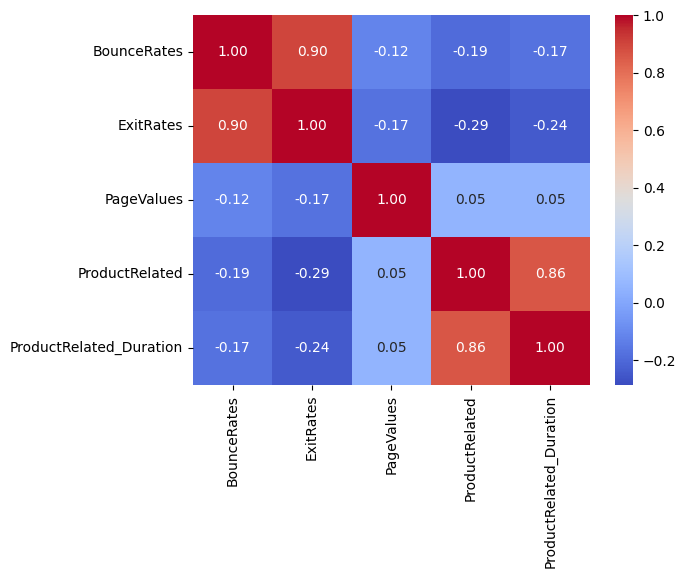

In [37]:
analytics = ['BounceRates', 'ExitRates', 'PageValues', 'ProductRelated', 'ProductRelated_Duration']
correlations = df[analytics].corr()
sns.heatmap(correlations, annot=True, cmap = 'coolwarm', fmt = '0.2f')


The high correlation between exit rate and bounce rate shows that including exit rates and bounce rates are informationally redundant. Bounce rates indicate visitors leaving without any engagement and exit rates indicate specifically which webpages visitors are exing out on. One could generalize the higher the exit rate the higher the bounce rate, which can show that **there are elements in a specific web page that cause visitors to leave without buying a product**. In other words, the higher the bounce rate the more likely there is something on a website that repels customer engagement. **Bounce rate can be excluded from the feature set because unengaging visitors are less likely to buy a product than visitors looking through the website.**

The positive correlation between ProductRelated and PageValues along with the negative correlation ProductRelated has with bounce rate and exit rate shows that visitors are more likely to buy a product as they visit more product related pages. 


The distribution of page values (avg visits to a page before purchase) will be analyzed becuase it can exhibit:

-Customer behavior before purchase: customers may know what they want before even reaching the site or they spend 

-How desireable a product may be 

Hypothetically, the closer to zero the distribution page values will be the easier it is to find a desired produt because, on average, visitors are clicking throug minimal pages to finalize their purchase. 

<Axes: xlabel='PageValues', ylabel='Count'>

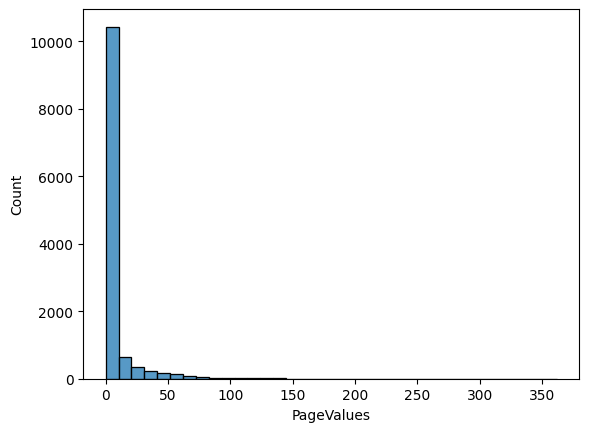

In [38]:
sns.histplot(df['PageValues'], bins = 35)

It seems that, on average, over 10,000 customers finalize their purchase clicking through approximately 1 to 10 pages.

The third group of features are related to customer inormation such as how new they are, which operating systems and browsers they use, which region they're logging in from and when they logged in. It is important to note that unlike the other groups of features these ones are purely categorical. Most of the variables in this group need a data type conversion since pandas reads most of them as either integers or floats.

After successfully converting the categorical variables to objects, the group is ready to be analyzed.

Analyzing visitor types will shed light on wheter the products on the website attract new customers and maintains previous visitors. 

In [39]:
df['VisitorType'].value_counts()

VisitorType
Returning_Visitor    10426
New_Visitor           1693
Other                   81
Name: count, dtype: int64

<Axes: xlabel='Month', ylabel='Count'>

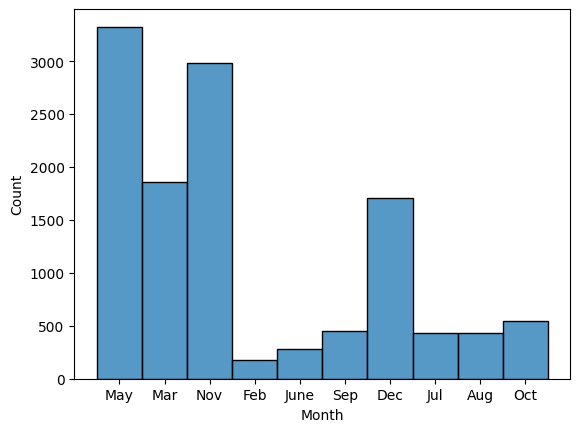

In [40]:
sns.histplot(df['Month'])

Seasonality is apparent in different times of the year. Must account for this difference somehow so that model does not make false geberalizations. Creating a an interaction variable that indicates high seasonality will help the model understand which sessions hold higher weight more efficiently. If months as object are hot encoded, the model model will have to interpret up to 10 dummy variables. Therefore:

-Sessions in May and November will be labeled high seasonality

-December and March sessions  will be labeled as medium seasonality

-The rest are low seasonality 



**Clustering Models**

In [16]:
#preprocessing to maintian all features
def precluster(dataframe):
    """ Preprocessing data for clustering algorithm
        Args: 
            dataframe: dataset to be analyzed 
        Returns: preprocessed dataset for clustering model
    """
    
    #convert float variable to bool
    dataframe['SpecialDay'] = dataframe['SpecialDay'].apply(lambda x: 1 if x == True else 0)
    dataframe['Weekend'] = dataframe['Weekend'].apply(lambda x: 1 if x == True else 0)
    categorical_variables = [i for i in dataframe.select_dtypes(include = object)]
    numerical_variables = [i for i in dataframe.select_dtypes(exclude = object)]
    #dataframe.drop(['Revenue'], axis = 1, inplace = True)
    dummy_variables = pd.get_dummies(dataframe[categorical_variables], drop_first = True)
    scaled_numerical_variables = [i for i in numerical_variables]
    array = dataframe[numerical_variables].values
    datascaler = pre.MinMaxScaler(feature_range = (0,1))
    dfscaled = pd.DataFrame(datascaler.fit_transform(array), columns = scaled_numerical_variables)
    modeldf = pd.concat([dummy_variables, dfscaled], axis = 1)
        
    #modeldf.to_csv('hclustering_data.csv', index = False)
    modeldf = modeldf.dropna()
    return modeldf
df1 = precluster(df.copy())


Each set of features will be fit to a hierarchical clustering model and displayed as a dendrogram. Additionally each set of features will be fit to a KNN clustering model.

**Hierarchical Clustering with Scipy**

In [17]:
#preprocessing duration based data set
def dappus(dataframe):
    """ Preprocessing data for clustering algorithm
        Args: 
            dataframe: dataset to be analyzed 
        Returns: preprocessed dataset for clustering model
    """
    dataframe

    #creating variable to indicate seasonality 
    dataframe['Seasonality'] = dataframe['Month'].apply(lambda x: 'High_Seasonality' if x in ['May', 'Nov'] else ('Medium_Seasonality' if x in ['Dec', 'Mar'] else 'Low_Seasonality'))
 


    #create feature set by excluding proposed variables
    drops = ['BounceRates', 'Administrative_Duration', 'Informational_Duration', 'Administrative', 'Informational', 'ProductRelated', 'Month', 'Revenue']
    dataframe.drop(drops, axis = 1, inplace = True)
    
    #separate numerical and categorical variables 

    categorical_variables = [i for i in dataframe.select_dtypes(include = object)]
    numerical_variables = [i for i in dataframe.select_dtypes(exclude = object) if i not in ['SpecialDay', 'Weekend']]
    dummy_variables = pd.get_dummies(dataframe[categorical_variables], drop_first = True)
    scaled_numerical_variables = [i for i in numerical_variables]
    array = dataframe[numerical_variables].values
    datascaler = pre.MinMaxScaler(feature_range = (0,1))
    dfscaled = pd.DataFrame(datascaler.fit_transform(array), columns = scaled_numerical_variables)
    modeldf = pd.concat([dummy_variables, dfscaled], axis = 1)
    modeldf = modeldf.dropna()
        
    #modeldf.to_csv('hclustering_data.csv', index = False)
    return modeldf


df2 = dappus(df.copy())

In [ ]:
#preprocess click based data set
def dappus(dataframe):
    """ Preprocessing data for clustering algorithm
        Args: 
            dataframe: dataset to be analyzed 
        Returns: preprocessed dataset for clustering model
    """
    dataframe

    #creating variable to indicate seasonality 
    dataframe['Seasonality'] = dataframe['Month'].apply(lambda x: 'High_Seasonality' if x in ['May', 'Nov'] else ('Medium_Seasonality' if x in ['Dec', 'Mar'] else 'Low_Seasonality'))
 


    #create feature set by excluding proposed variables
    drops = ['BounceRates', 'Administrative_Duration', 'Informational_Duration', 'Administrative', 'Informational', 'ProductRelated_Duration', 'Month', 'Revenue']
    dataframe.drop(drops, axis = 1, inplace = True)
    
    #separate numerical and categorical variables 

    categorical_variables = [i for i in dataframe.select_dtypes(include = object)]
    numerical_variables = [i for i in dataframe.select_dtypes(exclude = object) if i not in ['SpecialDay', 'Weekend']]
    dummy_variables = pd.get_dummies(dataframe[categorical_variables], drop_first = True)
    scaled_numerical_variables = [i for i in numerical_variables]
    array = dataframe[numerical_variables].values
    datascaler = pre.MinMaxScaler(feature_range = (0,1))
    dfscaled = pd.DataFrame(datascaler.fit_transform(array), columns = scaled_numerical_variables)
    modeldf = pd.concat([dummy_variables, dfscaled], axis = 1)
    modeldf = modeldf.dropna()
        
    #modeldf.to_csv('hclustering_data.csv', index = False)
    return modeldf


df3 = dappus(df.copy())

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
#creating function that creates dendrogram
def hclustering(dataframe):
    """
        Hierararchical clustering with scipy
        fitting of scipy hierarchachal clustering model with preprocessed data
        Args: 
            datframe: original dataframe to be analyzed
        Returns:
          results of hierarchachal cluster model fitting with preprocessed data """
   
    matrices = ward(dataframe.values)
    dist = 1 - cosine_similarity(matrices)
    linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

    fig, ax = plt.subplots(figsize=(10, 7)) # set size
    ax = dendrogram(dist, orientation="right");

    plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
    showtime = plt.show()
    return showtime


Feature Set 1

In [ ]:
hclustering(df1)

Data with inimal preprocessing was able to group data into two clusters

Feature Set 2:

-Includes duration of visitor time on website

-Stricter preprocessing

-Removing outliers 

In [16]:
hclustering(df2)

Fitting the duration based feature set the clustering model can generalize data into two general clusters. This is impressive because it classifies records into binary classes like true and false. 

hclusterinf(df3)

**KMeans Clustering**

In [25]:
import collections
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity

def kclustering(dataframe, clusters) :
    matrices = ward(dataframe.values)
    dist = 1 - cosine_similarity(matrices)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(matrices)

    clustering = collections.defaultdict(list)

    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)

    return clustering


clusters = kclustering(df2, 2)
pprint(dict(clusters))
for c, ms in dict(clusters).items():
    print('Cluster ', c, ':')
    for m in ms:
        print(df['Revenue'][m])

    print('\n')

: 

Support Vector Machines Modeling 


Feature Set 1: all of the variables

In [47]:
#need to preprocess the data for supervised learning algorthm 

def dappit(dataframe, target):
    """ Preprocessing data for clustering algorithm
        Args: 
            dataframe: dataset to be analyzed 
        Returns: preprocessed dataset for supervised machine learning
    """

    
    #separate numerical and categorical variables 

    categorical_variables = [i for i in dataframe.select_dtypes(include = object) if i != target]
    numerical_variables = [i for i in dataframe.select_dtypes(exclude = object) if i not in ['SpecialDay', 'Weekend']]
    dummy_variables = pd.get_dummies(dataframe[categorical_variables], drop_first = True)
    dataframe.drop(categorical_variables, axis = 1, inplace = True)
    

 
    numerical_variables = [i for i in numerical_variables]
    scaled_numerical_variables = [i for i in numerical_variables]
    array = dataframe[numerical_variables].values
    datascaler = pre.MinMaxScaler(feature_range = (0,1))
    dfscaled = pd.DataFrame(datascaler.fit_transform(array), columns = scaled_numerical_variables)
    dataframe.drop(numerical_variables, axis = 1, inplace = True) 
    modeldf = pd.concat([dataframe, dummy_variables, dfscaled], axis = 1)
    modeldf = modeldf.fillna(False)   
    #modeldf.to_csv('hclustering_data.csv', index = False)
    dataprev = modeldf.head()
    return modeldf


df1 = dappit(df.copy(), 'Revenue')
#df1['Revenue'].value_counts()
df1

/tmp/ipykernel_18884/2079732214.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  modeldf = modeldf.fillna(False)


,SpecialDay,Weekend,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,...,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,Revenue
0,False,True,False,False,False,False,False,True,False,False,...,0.0,0.0,0.0,0.0,0.011348,0.00347,0.0,0.142857,0.147816,1.0
1,False,False,False,False,False,False,True,False,False,False,...,0.0,0.0,0.0,0.0,0.019858,0.016218,0.071429,0.238095,0.0,0.0
2,False,False,False,False,False,False,False,False,True,False,...,0.148148,0.011033,0.083333,0.032165,0.005674,0.00151,0.0,0.0875,0.0,0.0
3,False,False,False,False,False,False,False,False,True,False,...,0.148148,0.034042,0.0,0.0,0.022695,0.010245,0.0,0.060185,0.0,0.0
4,False,False,False,False,False,False,False,True,False,False,...,0.037037,0.017654,0.041667,0.005884,0.036879,0.010476,0.0,0.019231,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12067,False,False,False,False,False,False,False,False,False,False,...,0.074074,0.008788,0.083333,0.039068,0.01844,0.008355,0.0,0.020833,0.0,0.0
12080,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,0.041667,0.033342,0.002837,0.000555,0.0,0.333333,0.0,0.0
12121,False,False,False,False,False,False,False,False,False,False,...,0.148148,0.021478,0.0,0.0,0.048227,0.01565,0.0,0.089796,0.0,0.0
12164,False,False,False,False,False,False,False,False,False,False,...,0.407407,0.024196,0.0,0.0,0.624113,0.155562,0.009251,0.050492,0.004308,0.0


In [48]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
X = df1.drop('Revenue', axis = 1)
y = df1['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and fitting the SVM model
svm_model = SVC(kernel='linear')  # You can specify other kernels too like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

Feature set 2: duration based data set

In [41]:
#need to preprocess the data for supervised learning algorthm 

def dappit(dataframe, target):
    """ Preprocessing data for clustering algorithm
        Args: 
            dataframe: dataset to be analyzed 
        Returns: preprocessed dataset for supervised machine learning
    """
    dataframe

    #creating variable to indicate seasonality 
    dataframe['Seasonality'] = dataframe['Month'].apply(lambda x: 'High_Seasonality' if x in ['May', 'Nov'] else ('Medium_Seasonality' if x in ['Dec', 'Mar'] else 'Low_Seasonality'))
 

    #create feature set by excluding proposed variables
    drops = ['BounceRates', 'Administrative_Duration', 'Informational_Duration', 'Administrative', 'Informational', 'ProductRelated', 'Month']
    dataframe.drop(drops, axis = 1, inplace = True)
    
    #separate numerical and categorical variables 

    categorical_variables = [i for i in dataframe.select_dtypes(include = object) if i != target]
    numerical_variables = [i for i in dataframe.select_dtypes(exclude = object) if i not in ['SpecialDay', 'Weekend']]
    dummy_variables = pd.get_dummies(dataframe[categorical_variables], drop_first = True)
    dataframe.drop(categorical_variables, axis = 1, inplace = True)
    

    #balancing target variable with oversampling
    def oversampler(dataframe, target):
        oversamp = SMOTE(random_state = 42)
        input_var = list(dataframe.columns)
        input_var.remove(target)
        X, y = oversamp.fit_resample(dataframe[input_var], dataframe[target])
        X = pd.DataFrame(X, columns = input_var)
        y = pd.DataFrame(y, columns = [i for i in dataframe.columns if i == 'Revenue'])
        dataframe = pd.concat([X, y], axis = 1)
        return dataframe

    dataframe = oversampler(dataframe, target)
    numerical_variables = [i for i in numerical_variables]
    scaled_numerical_variables = [i for i in numerical_variables]
    array = dataframe[numerical_variables].values
    datascaler = pre.MinMaxScaler(feature_range = (0,1))
    dfscaled = pd.DataFrame(datascaler.fit_transform(array), columns = scaled_numerical_variables)
    dataframe.drop(numerical_variables, axis = 1, inplace = True) 
    modeldf = pd.concat([dataframe, dummy_variables, dfscaled], axis = 1)
    modeldf = modeldf.fillna(False)   
    #modeldf.to_csv('hclustering_data.csv', index = False)
    dataprev = modeldf.head()
    return modeldf


df2 = dappit(df.copy(), 'Revenue')
#df2['Revenue'].value_counts()
df2

/tmp/ipykernel_18884/3219877947.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  modeldf = modeldf.fillna(False)


,SpecialDay,Weekend,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_2,...,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor,Seasonality_Low_Seasonality,Seasonality_Medium_Seasonality,ProductRelated_Duration,ExitRates,PageValues,Revenue
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.003470,0.142857,0.147816,1.0
1,False,False,True,False,False,False,False,False,False,True,...,False,False,False,True,False,True,0.016218,0.238095,0.000000,0.0
2,False,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,0.001510,0.087500,0.000000,0.0
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,0.010245,0.060185,0.000000,0.0
4,False,False,True,False,False,False,False,False,False,True,...,False,False,False,True,False,False,0.010476,0.019231,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20579,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.018246,0.068257,0.090081,1.0
20580,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.137010,0.084300,0.054303,1.0
20581,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.009669,0.028532,0.026529,1.0
20582,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.021932,0.019884,0.248855,1.0


In [42]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
X = df2.drop('Revenue', axis = 1)
y = df2['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and fitting the SVM model
svm_model = SVC(kernel='linear')  # You can specify other kernels too like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      3091
         1.0       0.96      0.88      0.92      3085

    accuracy                           0.92      6176
   macro avg       0.92      0.92      0.92      6176
weighted avg       0.92      0.92      0.92      6176



Featureset 2 : click based data set

In [43]:
#need to preprocess the data for supervised learning algorthm 

def dappit(dataframe, target):
    """ Preprocessing data for clustering algorithm
        Args: 
            dataframe: dataset to be analyzed 
        Returns: preprocessed dataset for supervised machine learning
    """
    dataframe

    #creating variable to indicate seasonality 
    dataframe['Seasonality'] = dataframe['Month'].apply(lambda x: 'High_Seasonality' if x in ['May', 'Nov'] else ('Medium_Seasonality' if x in ['Dec', 'Mar'] else 'Low_Seasonality'))
 

    #create feature set by excluding proposed variables
    drops = ['BounceRates', 'Administrative_Duration', 'Informational_Duration', 'Administrative', 'Informational', 'ProductRelated', 'Month']
    dataframe.drop(drops, axis = 1, inplace = True)
    
    #separate numerical and categorical variables 

    categorical_variables = [i for i in dataframe.select_dtypes(include = object) if i != target]
    numerical_variables = [i for i in dataframe.select_dtypes(exclude = object) if i not in ['SpecialDay', 'Weekend']]
    dummy_variables = pd.get_dummies(dataframe[categorical_variables], drop_first = True)
    dataframe.drop(categorical_variables, axis = 1, inplace = True)
    

    #balancing target variable with oversampling
    def oversampler(dataframe, target):
        oversamp = SMOTE(random_state = 42)
        input_var = list(dataframe.columns)
        input_var.remove(target)
        X, y = oversamp.fit_resample(dataframe[input_var], dataframe[target])
        X = pd.DataFrame(X, columns = input_var)
        y = pd.DataFrame(y, columns = [i for i in dataframe.columns if i == 'Revenue'])
        dataframe = pd.concat([X, y], axis = 1)
        return dataframe

    dataframe = oversampler(dataframe, target)
    numerical_variables = [i for i in numerical_variables]
    scaled_numerical_variables = [i for i in numerical_variables]
    array = dataframe[numerical_variables].values
    datascaler = pre.MinMaxScaler(feature_range = (0,1))
    dfscaled = pd.DataFrame(datascaler.fit_transform(array), columns = scaled_numerical_variables)
    dataframe.drop(numerical_variables, axis = 1, inplace = True) 
    modeldf = pd.concat([dataframe, dummy_variables, dfscaled], axis = 1)
    modeldf = modeldf.fillna(False)   
    #modeldf.to_csv('hclustering_data.csv', index = False)
    dataprev = modeldf.head()
    return modeldf


df3 = dappit(df.copy(), 'Revenue')
#df3['Revenue'].value_counts()
df3

/tmp/ipykernel_18884/3609854237.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  modeldf = modeldf.fillna(False)


,SpecialDay,Weekend,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_2,...,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor,Seasonality_Low_Seasonality,Seasonality_Medium_Seasonality,ProductRelated_Duration,ExitRates,PageValues,Revenue
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.003470,0.142857,0.147816,1.0
1,False,False,True,False,False,False,False,False,False,True,...,False,False,False,True,False,True,0.016218,0.238095,0.000000,0.0
2,False,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,0.001510,0.087500,0.000000,0.0
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,0.010245,0.060185,0.000000,0.0
4,False,False,True,False,False,False,False,False,False,True,...,False,False,False,True,False,False,0.010476,0.019231,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20579,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.018246,0.068257,0.090081,1.0
20580,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.137010,0.084300,0.054303,1.0
20581,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.009669,0.028532,0.026529,1.0
20582,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.021932,0.019884,0.248855,1.0


In [44]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
X = df3.drop('Revenue', axis = 1)
y = df3['Revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and fitting the SVM model
svm_model = SVC(kernel='linear')  # You can specify other kernels too like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      3091
         1.0       0.96      0.88      0.92      3085

    accuracy                           0.92      6176
   macro avg       0.92      0.92      0.92      6176
weighted avg       0.92      0.92      0.92      6176



**Conclusion**

The best performing models to predict whether a customer will buy a product are Support Vector Machines.